In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from erddapy import ERDDAP
import json
import re

Configure the ERDDAP to search

In [2]:
ra = 'AOOS'

with open('utils/ra_erddaps.json') as f:
    urls = json.load(f)

server = urls[ra.lower()]

print(server)

e = ERDDAP(server=server, protocol="tabledap")

http://erddap.aoos.org/erddap


Pull in the processed inventory

In [3]:
#
# df_cruise = df[df['Station Description'] == 'Chesapeake Bay WQ Cruise Data ']
#
#df_aws = df[df['Station ID'] == 'Humboldt']
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/OMOECC_E1/OMOECC_E1.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/45186/45186.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/bgsusd2/bgsusd2.ncml'
# url = 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/nss/ns12agg'
# print(url)
# ds = xr.open_dataset(url)
# #ds = netCDF4.Dataset(url,'r')
# title = ds.title
# start_time = np.datetime_as_string(ds.time.min().values, unit='D')
# end_time = np.datetime_as_string(ds.time.max().values, unit='D')
# print('Duration: %s - %s' % (np.datetime_as_string(ds.time.min().values, unit='D'),
#                              np.datetime_as_string(ds.time.max().values, unit='D'))
#       )

# Try glos web server
# url = 'https://glbuoys.glos.us/tools/export?ftype=csv&data_type=buoy&units=eng&locs=OMOECC_E1&params=Water_Temperature_at_Surface|dissolved_oxygen_saturation|water_conductivity|ysi_turbidity&tperiod=custom&date_start=2020-01-01&date_end=2020-12-31&avg_ivld=none'
# df = erddapy.ERDDAP.to_pandas(url)

## using ERDDAP to look for stations
# check out http://data.glos.us/erddap/tabledap/allDatasets.htmlTable?datasetID%2Ctitle%2CminTime%2CmaxTime&maxTime%3E=2020-01-01&maxTime%3C=2020-12-31&orderBy(%22maxTime%22)
# that lists out all the GLOS stations with the maximum time of observations within the year 2020 (on their ERDDAP).


ra_clean = re.sub(r'[0-9]', '', ra) # remove number from RA 

df = pd.read_excel('2023/data/processed/%s.xlsx' % ra_clean.upper(), dtype=str)
df

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
0,AOOS,CSESM,NOT REAL TIME,Chukchi Sea Ecosystem Mooring (CSESM) Array,Hannah Shoal subsurface ecosystem mooring with...,71.5997,-161.5054,moored_buoy,2014-09-20 00:00:00,Y - but never real time,"AOOS, NPRB, UAF, others",Yp,UAF_CFOS,Academic,UAF,North Pacific Research Board,"sea_water_temperature (35m, 48m, near-bottom),...",two to three moorings at the CEO which are rot...
1,AOOS,CEO1,Not real time,CEO1 (part of the CSEM),NaN,71.5997,-161.5054,moored_buoy,2014-09-21 00:00:00,Y - but never real time,same as above,Yp,UAF-CFOS,Academic,UAF,North Pacific Research Board,"sea_water_temperature, sea_water_electrical_co...",Data visualizaed on the AOOS Portal includes 2...
2,AOOS,CEO2,Not real time,CEO2 (part of the CSEM),NaN,71.5998,-161.5261,moored_buoy,2015-08-20 00:00:00,Y- but never real time,sames as above,Yp,UAF-CFOS,Academic,UAF,North Pacific Research Board,"sea_water_temperature, sea_water_electrical_co...",This is the list of all sensors reporting to t...
3,AOOS,urn:gulf-of-alaska-ecosystem-obse,not reporting real time anymore,Gulf of Alaska Ecosystem Observatory-GEO1,"Surface real time mooring: CDOM, 150kHz ADCP, ...",59.0142,-148.6902,Fixed moored_buoy,2019-07-11 00:00:00,"Y - but not real time at moment, so data not u...","M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,NSF,"Real time mooring: 150kHz ADCP (205m), SBE 37 ...",The buoy was not serving real time data feeds ...
4,AOOS,urn:gulf-of-alaska-ecosystem-obse-1,not reporting real time anymore,Gulf of Alaska Ecosystem Observatory-GEO3,"Surface real time mooring: GPS, wind speed, wi...",59.0165,-148.6966,Fixed moored_buoy,2019-07-11 00:00:00,Y - but not real time at moment,"M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,NSF,"Real time mooring: GPS, wind_speed, wind_from_...","Note: The 5 m SBE 37 CTD (Conductivity, temper..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,AOOS,skan-bay-unalaska-island-ak,New 2022,"Skan Bay Weather Station, Unalaska Island, AK","MET Station in Skan Bay, Unalaska, AK",53.6185,-167.0628,Fixed,2022-08-16 00:00:00,Y,"NSF, UNCW-CMS",N,UNCW-Coastal Ocean Research and Monitoring Pro...,Academic,"University of North Carolina, Willimington (UNCW)",UNCW,"air_pressure, dew_point_temperature, relative_...","NSF Bering Sea Storms Project, Sea Level Resea..."
136,AOOS,shagak-bay-inner-wave-buoy,New 2022,Shagak Bay Inner Wave Buoy,SOFAR Spotter Wave Buoy in Shagak Bay,51.8744,-176.7443,Moored Buoy,2022-08-12 00:00:00,Y,"NSF, UNCW-CMS",N,UNCW-Coastal Ocean Research and Monitoring Pro...,Academic,"University of North Carolina, Willimington (UNCW)",SOFAR OCEAN,"sea_surface_wave_significant_height, sea_surfa...","NSF Bering Sea Storms Project, Sea Level Resea..."
137,AOOS,st-paul-island-wave-buoy,New 2022,St. Paul Island Wave Buoy,SOFAR Spotter Wave Buoy in Skan Bay (outer bay),57.1208,-170.3825,Moored Buoy,2022-09-20 00:00:00,O,"University of Alaksa, Fairbanks Geophysical In...",N,NaN,Academic,UAF GI,SOFAR OCEAN,"sea_surface_wave_significant_height, sea_surfa...",Project buoy deployments for which AOOS is sha...
138,AOOS,noaa_nos_co_ops_9454050,CRVA2,"Cordova, AK",NOAA NWLON station in Cordova equipped with AO...,60.5583,-145.755,Fixed,Tide Gage: 08/31/78; NWLON CTD installed 11/03...,Y,"NOAA CO-OPS, AOOS",Yp,NOAA _NWLON,Federal,PWSSC-Prince William Sound Science Center,NOAA CO-OPS,"air_pressure, sea_water_electrical_conductivit...",I have added this station so IOOS knows that A.

Search the ERDDAP server for a single station of interest - more of a test

In [4]:
# df['Station ID'].loc[df['Station ID'].isna()] = df.loc[df['Station ID'].isna(),'Dataset ID']

# df['Station ID']

In [5]:
# df_wf = df[df['Station ID'] == 'Jug_Bay']

# # for SCCOOS need to search for 'Station Long Name' as 'Station ID' is NA for most entries
# search_for = df_wf['Station ID'].to_string()

# search_url = e.get_search_url(search_for=search_for, response="csv")

# try:
#     resp = pd.read_csv(search_url)
#     print(resp['Station ID'])
# except:
#     pass

Rip through all the datasets in the inventory and see if they exist on the RA erddap. Process checks the following order:

1. `Station ID`, then 
2. `Station Long Name`, then
3. `WMO ID or NWS/CMAN ID`

We first check if the value is `nan`. If so, we punt as that will return all datasets from the ERDDAP service.

In [6]:
not_found = []
found = dict()

exclude = ' -gliders'

#search_order = ['Station ID', 'Station Long Name', 'WMO ID or NWS/CMAN ID']

# GLOS
search_order = ['Station ID', 'Station Long Name', 'WMO ID or NWS/CMAN ID']
# SCCOOS
#search_order = ['Station Long Name', 'WMO ID or NWS/CMAN ID', 'Station Description']

for search1 in df[search_order[0]].astype(str):
    
    if search1 == "nan":
        print("punting with %s = nan\n" % search_order[0])
        not_found.append(search1)
        continue
    
    try:
        print('searching \"%s\" = \"%s\"' % (search_order[0], search1))
        search_url = e.get_search_url(search_for=search1+exclude, response="csv")
        resp = pd.read_csv(search_url)
        
        print("Found \"%s\": %s" % (search1,resp['Dataset ID'].values.tolist()))
        
        found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
        
    except:
        
        print('no dataset matching \"%s\"' % search1)
        search2 = df.loc[df[search_order[0]] == search1, search_order[1]].values.tolist()[0]
        
        if search2 == "nan":
                print("punting with %s = nan\n" % search_order[1])
                not_found.append(search1)
                continue
                
        try:
            
            print('searching \"%s\" = \"%s\"' % (search_order[1], search2))
            search_url = e.get_search_url(search_for=search2+exclude, response="csv")
            resp = pd.read_csv(search_url)
            print("Found \"%s\": %s" % (search2,resp['Dataset ID'].values.tolist()))
            
            found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
            
        except:

            search3 = str(df.loc[df[search_order[0]] == search1, search_order[2]].values.tolist()[0])
            
            if search3 == "nan":
                print("punting with \"%s\" = nan\n" % search_order[2])
                not_found.append(search1)
                continue
            
            try:
                print('searching \"%s\" = \"%s\"' % (search_order[2], search3))
                search_url = e.get_search_url(search_for=search3+exclude, response="csv")
                resp = pd.read_csv(search_url)
                print("Found \"%s\": %s" % (search3,resp['Dataset ID'].values.tolist()))
                
                found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
                
            except:
                print("Couldn't find:", [search1, search2, search3])
                not_found.append(search1)
        
    print("\n")

searching "Station ID" = "CSESM"
no dataset matching "CSESM"
searching "Station Long Name" = "Chukchi Sea Ecosystem Mooring (CSESM) Array"
searching "WMO ID or NWS/CMAN ID" = "NOT REAL TIME "
Found "NOT REAL TIME ": ['ca_hydro_07HC001', 'edu_uaf_werc_pvs_yukon_river_galena', 'edu_uaf_werc_pvs_innoko_river_shageluk', 'edu_uaf_werc_pvs_tanana_river_fairbanks', 'edu_uaf_werc_pvs_copper_river_tazlina', 'edu_uaf_werc_pvs_kantishna_river_tanana', 'ca_hydro_05DE006', 'ca_hydro_08HDX24', 'ca_hydro_08GAX43', 'ca_hydro_07FAX06', 'ca_hydro_07FBX08', 'ca_hydro_08NBX17', 'ca_hydro_08NB019', 'ca_hydro_08MB005', 'ca_hydro_08EG016', 'ca_hydro_08MC039', 'ca_hydro_08HD003', 'ca_hydro_10KD001', 'ca_hydro_07SB002', 'big-lake-venetie-ak', 'third-lake-noatak-ak', 'yugayu-lake-bethel-ak', 'pleasant-lake-nenana-ak', 'tsa-bene-kenny-lake-ak', 'dzan-lake-chalkyitsik-ak', 'richard-s-pond-nuiqsut-ak', 'shageluk-lake-shageluk-ak', 'sam-charley-oxbow-fairbanks-ak', 'takomahto-lake-near-northway-ak', 'west-two-lake-

Found "CEO1": ['ceo1']


searching "Station ID" = "CEO2"
Found "CEO2": ['ceo2']


searching "Station ID" = "urn:gulf-of-alaska-ecosystem-obse"
no dataset matching "urn:gulf-of-alaska-ecosystem-obse"
searching "Station Long Name" = "Gulf of Alaska Ecosystem Observatory-GEO1"
searching "WMO ID or NWS/CMAN ID" = "not reporting real time anymore"
Couldn't find: ['urn:gulf-of-alaska-ecosystem-obse', 'Gulf of Alaska Ecosystem Observatory-GEO1', 'not reporting real time anymore']


searching "Station ID" = "urn:gulf-of-alaska-ecosystem-obse-1"
no dataset matching "urn:gulf-of-alaska-ecosystem-obse-1"
searching "Station Long Name" = "Gulf of Alaska Ecosystem Observatory-GEO3"
searching "WMO ID or NWS/CMAN ID" = "not reporting real time anymore"
Couldn't find: ['urn:gulf-of-alaska-ecosystem-obse-1', 'Gulf of Alaska Ecosystem Observatory-GEO3', 'not reporting real time anymore']


searching "Station ID" = "urn:ioos:station:org.gulfwatchalaska:GAK1"
no dataset matching "urn:ioos:station:org.gulfw

no dataset matching "urn:ioos:station:gov.noaa.pmel:GAK_Seward"
searching "Station Long Name" = "GAKOA-Gulf of Alaska Ocean Acidification Mooring"
searching "WMO ID or NWS/CMAN ID" = "No longer reporting real time on AOOS Portal"
Couldn't find: ['urn:ioos:station:gov.noaa.pmel:GAK_Seward', 'GAKOA-Gulf of Alaska Ocean Acidification Mooring', 'No longer reporting real time on AOOS Portal']


searching "Station ID" = "urn:ioos:station:gov.noaa.pmel:m2"
no dataset matching "urn:ioos:station:gov.noaa.pmel:m2"
searching "Station Long Name" = "M2 - Ocean Acidification Mooring and Ecosytem Observatory"
searching "WMO ID or NWS/CMAN ID" = "No longer reporting real time on AOOS Portal"
Couldn't find: ['urn:ioos:station:gov.noaa.pmel:m2', 'M2 - Ocean Acidification Mooring and Ecosytem Observatory', 'No longer reporting real time on AOOS Portal']


searching "Station ID" = "M8 - this is a federal station AOOS is partially supporting"
no dataset matching "M8 - this is a federal station AOOS is part

no dataset matching "urn:ioos:station:org.mxak:AKUTAN_WX"
searching "Station Long Name" = "Akutan, Port"
Found "Akutan, Port": ['akutan-1', 'noaa_nos_co_ops_9462691', 'noaa_nos_co_ops_9462694', 'noaa_nos_co_ops_9462711', 'org_mxak_akutan_wx']


searching "Station ID" = "urn:ioos:station:org.mxak:ANCHORAGE_PORT"
no dataset matching "urn:ioos:station:org.mxak:ANCHORAGE_PORT"
searching "Station Long Name" = "Anchorage Port"
Found "Anchorage Port": ['org_mxak_anchorage_port', 'gov_noaa_awc_pamr', 'gov_noaa_awc_panc', 'miscwebcam_11', 'gov_noaa_nws_hads_ddcda04a', 'gov_noaa_nws_hads_15cf67be', 'gov_noaa_nws_hads_ddcd95d0', 'gov_noaa_nws_hads_15d101ae', 'gov_usgs_waterdata_15276000', 'gov_usgs_waterdata_15275100', 'noaa_nos_co_ops_9451826', 'noaa_nos_co_ops_9459464', 'noaa_nos_co_ops_9454573', 'noaa_nos_co_ops_9450271', 'noaa_nos_co_ops_9450862', 'noaa_nos_co_ops_9458917', 'noaa_nos_co_ops_9450544', 'gov_usgs_nwis_15275100', 'gov_usgs_nwis_15276000', 'noaa_nos_co_ops_9455920', 'gov_noaa_awc_

no dataset matching "urn:ioos:station:org.mxak:LITTLE_ISLAND"
searching "Station Long Name" = "Little Island"
Found "Little Island": ['org_mxak_little_island']


searching "Station ID" = "urn:ioos:station:org.mxak:MARMION_ISLAND"
no dataset matching "urn:ioos:station:org.mxak:MARMION_ISLAND"
searching "Station Long Name" = "Marmion Island"
Found "Marmion Island": ['org_mxak_marmion_island']


searching "Station ID" = "urn:ioos:station:org.mxak:MARY_ISLAND"
no dataset matching "urn:ioos:station:org.mxak:MARY_ISLAND"
searching "Station Long Name" = "Mary Island"
Found "Mary Island": ['org_mxak_mary_island', 'noaa_nos_co_ops_9450296', 'net_cvinternet_naked', 'org_pws_osri_28', 'boem_ahmd_cross_island', 'boem_ahmd_reindeer_island', 'boem_ahmd_cottle_island', 'amchitka-island', 'ca_hydro_10LC020', 'ca_hydro_07FD934', 'com_micro_specialties_2_sn275', 'wmo_auga2', 'boem_ahmd_challenge_island', 'wmo_fila2', 'ca_hydro_10MC011', 'eastern-nunivak-island', 'geese-island-gps-tide-buoy', 'ca_hydro_1

no dataset matching "urn:ioos:station:org.mxak:NOME"
searching "Station Long Name" = "Nome WX, Port Breakwater"
searching "WMO ID or NWS/CMAN ID" = "NMXA2"
Found "NMXA2": ['org_mxak_nome']


searching "Station ID" = "pelican-ak"
Found "pelican-ak": ['pelican-ak']


searching "Station ID" = "urn:ioos:station:org.mxak:POINT_ARDEN"
no dataset matching "urn:ioos:station:org.mxak:POINT_ARDEN"
searching "Station Long Name" = "Point Arden, AK"
Found "Point Arden, AK": ['org_mxak_point_arden']


searching "Station ID" = "point-craven-ak"
Found "point-craven-ak": ['point-craven-ak']


searching "Station ID" = "urn:ioos:station:org.mxak:POINT_GARDNER"
no dataset matching "urn:ioos:station:org.mxak:POINT_GARDNER"
searching "Station Long Name" = "Point Gardner "
Found "Point Gardner ": ['org_mxak_point_gardner']


searching "Station ID" = "point-pigot-ak"
Found "point-pigot-ak": ['point-pigot-ak']


searching "Station ID" = "urn:ioos:station:org.mxak:PORTLAND_ISLAND"
no dataset matching "urn:ioos:

punting with "WMO ID or NWS/CMAN ID" = nan

searching "Station ID" = "barry-arm-east"
Found "barry-arm-east": ['barry-arm-east']


searching "Station ID" = "barry-arm-west"
Found "barry-arm-west": ['barry-arm-west']


searching "Station ID" = "harbor-mountain-1"
Found "harbor-mountain-1": ['harbor-mountain-1']


searching "Station ID" = "mt-doran"
Found "mt-doran": ['mt-doran']


searching "Station ID" = "mount-riley-1"
Found "mount-riley-1": ['mount-riley-1']


searching "Station ID" = "scott-glacier"
Found "scott-glacier": ['scott-glacier']


searching "Station ID" = "takshanuk-mountains-2"
Found "takshanuk-mountains-2": ['takshanuk-mountains-2']


searching "Station ID" = "cape-spencer-ak"
Found "cape-spencer-ak": ['cape-spencer-ak']


searching "Station ID" = "peterson-bay-ak-gnss-r"
Found "peterson-bay-ak-gnss-r": ['peterson-bay-ak-gnss-r']


searching "Station ID" = "st-michaels-bay-ak"
Found "st-michaels-bay-ak": ['st-michaels-bay-ak']


searching "Station ID" = "utqiagvik-ak"
F

Print the stations that we couldn't find.

In [7]:
len(not_found)

10

In [8]:
len(found)

130

Show me the record that has NaN for the first search element.

In [9]:
df.loc[df[search_order[0]].isna()]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes


Now show me the stations, with identifiers, that we couldn't find.

In [10]:
df[df[search_order[0]].isin(not_found)]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
3,AOOS,urn:gulf-of-alaska-ecosystem-obse,not reporting real time anymore,Gulf of Alaska Ecosystem Observatory-GEO1,"Surface real time mooring: CDOM, 150kHz ADCP, ...",59.0142,-148.6902,Fixed moored_buoy,2019-07-11 00:00:00,"Y - but not real time at moment, so data not u...","M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,NSF,"Real time mooring: 150kHz ADCP (205m), SBE 37 ...",The buoy was not serving real time data feeds ...
4,AOOS,urn:gulf-of-alaska-ecosystem-obse-1,not reporting real time anymore,Gulf of Alaska Ecosystem Observatory-GEO3,"Surface real time mooring: GPS, wind speed, wi...",59.0165,-148.6966,Fixed moored_buoy,2019-07-11 00:00:00,Y - but not real time at moment,"M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,NSF,"Real time mooring: GPS, wind_speed, wind_from_...","Note: The 5 m SBE 37 CTD (Conductivity, temper..."
6,AOOS,urn:ioos:station:gov.noaa.pmel:GAK_Seward,No longer reporting real time on AOOS Portal,GAKOA-Gulf of Alaska Ocean Acidification Mooring,"Resurrection Bay, Seward, Real-time OA parameters",59.85,-149.5,moored_buoy,2011-05-19 00:00:00,Y,"AOOS, NOAA",Yp,NOAA_PMEL,gov_federal,"NOAA PMEL, UAF_OARC",NOAA,"dissolved_carbon_dixoide_ppm, partial_pressure...","Though AOOS Supported, these data are Not repo..."
7,AOOS,urn:ioos:station:gov.noaa.pmel:m2,No longer reporting real time on AOOS Portal,M2 - Ocean Acidification Mooring and Ecosytem ...,"Bering Sea, Real-time OA parameters",56.87,-164.06,moored_buoy,1905-07-03 00:00:00,Y,"NOAA, AOOS",Yp,NOAA_PMEL,gov_federal,"NOAA, PMEL, UAF_OARC",NOAA,"dissolved_carbon_dixoide_ppm, partial_pressure...","Though AOOS Supported, the data are Not report..."
21,AOOS,urn:ioos:station:org.mxak:GAMBELL,BGBXA2,"Gambell, St. Lawrence Island",Weather and AIS eATON/Transceiver,63.776913,-171.71531,Fixed,2019-05-31 00:00:00,Y,"AOOS, MXAK",Yp,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",NaN
71,AOOS,org-mxak-togiak,NaN,"Tokiak, AK",Weather (AIS Status unknown),59.0551,-160.3336,Fixed,2023-11-16 00:00:00,Y,MXAK,Yp,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",new 2023
88,AOOS,kodiak-burke-o-lator-kodiak-ak,NaN,"Kodiak Burke-o-Lator, Kodiak, AK","NOAA AFSC Operated Kodiak Burke-o-Lator, Kodia...",57.79,-152.41,Fixed,2022-10-01 00:00:00,Y,"NOAA AFSC, AOOS",Yp,NOAA Alaska Fisheries Science Center (AFSC),Federal,NOAA AFSC,IPACOA and NOAA,"dissolved_carbon_dioxide_co2, pco2, omega_arag...",AOOS started supporting BOL operatrions in Kod...
89,AOOS,urn:ioos:station:org.hakai:Sitka,NaN,Sitka Burke-o-Lator,Sitka Tribe of Alaska Burke-O-Lator,57.0526,-135.3456,Fixed,2017-06-27 00:00:00,Y,BIA Climate Change Grant,Yp,Sitka Tribe of Alaska,Tribal,"Sitka Tribe of Alaska, Hakai Institute",IPACOA,"dissolved_carbon_dioxide_co2, pco2, omega_arag...",AOOS supports BoL OnM through Hakai and provid...
90,AOOS,org_hakai_quadra,NaN,"Hyacinthe Bay, BC Buke-o-Lator","Hyancinthe Bay in British Columbia, operated b...",50.116,-125.222,Fixed,2018-06-30 00:00:00,Y,"Hakai Institute, Tula Foundation",N,Hakai Institute,"nonprofit, Research",Hakai Institute,IPACOA,"dissolved_carbon_dioxide_co2, pco2, omega_arag...",AOOS now hosts Hakai BC (Canada) real time OA ...
118,AOOS,urn:ioos:station:gov.usda.nrcs.wcc.snotel:1074,NaN,"Nuchek, SNOTEL STATION (on McNeil River)",SNOTEL station,60.335,-146.665,Fixed,2004-10-0

Print out all the dataset IDs for the datasets that matched our criteria.

In [11]:
found

{'CSESM': {'Dataset ID': ['ca_hydro_07HC001',
   'edu_uaf_werc_pvs_yukon_river_galena',
   'edu_uaf_werc_pvs_innoko_river_shageluk',
   'edu_uaf_werc_pvs_tanana_river_fairbanks',
   'edu_uaf_werc_pvs_copper_river_tazlina',
   'edu_uaf_werc_pvs_kantishna_river_tanana',
   'ca_hydro_05DE006',
   'ca_hydro_08HDX24',
   'ca_hydro_08GAX43',
   'ca_hydro_07FAX06',
   'ca_hydro_07FBX08',
   'ca_hydro_08NBX17',
   'ca_hydro_08NB019',
   'ca_hydro_08MB005',
   'ca_hydro_08EG016',
   'ca_hydro_08MC039',
   'ca_hydro_08HD003',
   'ca_hydro_10KD001',
   'ca_hydro_07SB002',
   'big-lake-venetie-ak',
   'third-lake-noatak-ak',
   'yugayu-lake-bethel-ak',
   'pleasant-lake-nenana-ak',
   'tsa-bene-kenny-lake-ak',
   'dzan-lake-chalkyitsik-ak',
   'richard-s-pond-nuiqsut-ak',
   'shageluk-lake-shageluk-ak',
   'sam-charley-oxbow-fairbanks-ak',
   'takomahto-lake-near-northway-ak',
   'west-two-lake-between-galena-',
   'little-paimute-lake-between-holy',
   'org_inletkeeper_deshka_river',
   'org_inle

Check if each found dataset has coverage for specified CY

In [12]:
valid_datasets = []

cy = '2023'

for key in found:
    
    dataset_id = found[key]['Dataset ID']
    
    if len(dataset_id)>1:
        
        for dataset in dataset_id:
            
            e.dataset_id = dataset
    
            e.constraints = {
                 "time>=": "{}-01-01".format(cy)
            }
        
            e.variables = ['time']
    
            try:
                df_data = e.to_pandas(parse_dates=True)
                valid_datasets.extend([key])
                
            except:
                pass

                #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

    else:
        
        e.dataset_id = dataset_id[0]
    
        e.constraints = {
                         "time>=": "{}-01-01".format(cy)
                        }
        
        e.variables = ['time']
        
        try:
            
            df_data = e.to_pandas(parse_dates=True)

            valid_datasets.extend([key])

        except:
            pass

            #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

            
#for valid in sorted(set(valid_datasets)):
    
#     # drop qc vars
#     cols = [c for c in df_data.columns if 'qc' not in c]
#     cols = [c for c in cols if 'QARTOD' not in c]

#     df_data = df_data[cols]

#     # set index for plotting
#     df_data = df_data.set_index(df_data['time (UTC)'])

#     # plot
#     #df_data.plot(subplots=True, title=e.dataset_id,figsize=(20,20))

#     start_time = df_data['time (UTC)'].min()
#     end_time = df_data['time (UTC)'].max()

#     print('Dataset %s' % e.dataset_id)
#     print('Duration: %s - %s' % (start_time, end_time))

no_cov_datasets = found.keys() - sorted(set(valid_datasets))

print('Datasets without coverage for {}:\n{}'.format(cy,no_cov_datasets))

Datasets without coverage for 2023:
{'CEO2', 'CEO1'}


Show me the inventory metadata about the invalid stations:

In [13]:
bad_stations = df.loc[(df[search_order[0]].isin(no_cov_datasets)) | df[search_order[0]].isin(not_found)]

df['erddap_not_avail'] = df[search_order[0]].isin(bad_stations[search_order[0]])

df.loc[df['erddap_not_avail']]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes,erddap_not_avail
1,AOOS,CEO1,Not real time,CEO1 (part of the CSEM),NaN,71.5997,-161.5054,moored_buoy,2014-09-21 00:00:00,Y - but never real time,same as above,Yp,UAF-CFOS,Academic,UAF,North Pacific Research Board,"sea_water_temperature, sea_water_electrical_co...",Data visualizaed on the AOOS Portal includes 2...,True
2,AOOS,CEO2,Not real time,CEO2 (part of the CSEM),NaN,71.5998,-161.5261,moored_buoy,2015-08-20 00:00:00,Y- but never real time,sames as above,Yp,UAF-CFOS,Academic,UAF,North Pacific Research Board,"sea_water_temperature, sea_water_electrical_co...",This is the list of all sensors reporting to t...,True
3,AOOS,urn:gulf-of-alaska-ecosystem-obse,not reporting real time anymore,Gulf of Alaska Ecosystem Observatory-GEO1,"Surface real time mooring: CDOM, 150kHz ADCP, ...",59.0142,-148.6902,Fixed moored_buoy,2019-07-11 00:00:00,"Y - but not real time at moment, so data not u...","M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,NSF,"Real time mooring: 150kHz ADCP (205m), SBE 37 ...",The buoy was not serving real time data feeds ...,True
4,AOOS,urn:gulf-of-alaska-ecosystem-obse-1,not reporting real time anymore,Gulf of Alaska Ecosystem Observatory-GEO3,"Surface real time mooring: GPS, wind speed, wi...",59.0165,-148.6966,Fixed moored_buoy,2019-07-11 00:00:00,Y - but not real time at moment,"M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,NSF,"Real time mooring: GPS, wind_speed, wind_from_...","Note: The 5 m SBE 37 CTD (Conductivity, temper...",True
6,AOOS,urn:ioos:station:gov.noaa.pmel:GAK_Seward,No longer reporting real time on AOOS Portal,GAKOA-Gulf of Alaska Ocean Acidification Mooring,"Resurrection Bay, Seward, Real-time OA parameters",59.85,-149.5,moored_buoy,2011-05-19 00:00:00,Y,"AOOS, NOAA",Yp,NOAA_PMEL,gov_federal,"NOAA PMEL, UAF_OARC",NOAA,"dissolved_carbon_dixoide_ppm, partial_pressure...","Though AOOS Supported, these data are Not repo...",True
7,AOOS,urn:ioos:station:gov.noaa.pmel:m2,No longer reporting real time on AOOS Portal,M2 - Ocean Acidification Mooring and Ecosytem ...,"Bering Sea, Real-time OA parameters",56.87,-164.06,moored_buoy,1905-07-03 00:00:00,Y,"NOAA, AOOS",Yp,NOAA_PMEL,gov_federal,"NOAA, PMEL, UAF_OARC",NOAA,"dissolved_carbon_dixoide_ppm, partial_pressure...","Though AOOS Supported, the data are Not report...",True
21,AOOS,urn:ioos:station:org.mxak:GAMBELL,BGBXA2,"Gambell, St. Lawrence Island",Weather and AIS eATON/Transceiver,63.776913,-171.71531,Fixed,2019-05-31 00:00:00,Y,"AOOS, MXAK",Yp,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",NaN,True
71,AOOS,org-mxak-togiak,NaN,"Tokiak, AK",Weather (AIS Status unknown),59.0551,-160.3336,Fixed,2023-11-16 00:00:00,Y,MXAK,Yp,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",new 2023,True
88,AOOS,kodiak-burke-o-lator-kodiak-ak,NaN,"Kodiak Burke-o-Lator, Kodiak, AK","NOAA AFSC Operated Kodiak Burke-o-Lator, Kodia...",57.79,-152.41,Fixed,2022-10-01 00:00:00,Y,"NOAA AFSC, AOOS",Yp,NOAA Alaska Fisheries Science Center (AFSC),Federal,NOAA AFSC,IPACOA and NOAA,"dissolved_carbon_dioxide_co2, pco2, omega_arag...",AOOS started supporting BOL operatrions in Kod...,True
89,AOOS,urn:ioos:station:org.hakai:Sitka,NaN,Sitka Burke-o-Lator,Sitka Tribe of Alaska Burke-O-Lator,57.0526,-135.3456,Fixed,2017-06-27 00:00:00,Y,BIA Climate Change Grant,Yp,Sitka Tribe of Alaska,Tribal

Invert the `erddap_not_avail` column and drop it.

In [14]:
df['erddap_avail'] = ~df['erddap_not_avail']

df.drop(columns='erddap_not_avail', inplace=True)

df

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes,erddap_avail
0,AOOS,CSESM,NOT REAL TIME,Chukchi Sea Ecosystem Mooring (CSESM) Array,Hannah Shoal subsurface ecosystem mooring with...,71.5997,-161.5054,moored_buoy,2014-09-20 00:00:00,Y - but never real time,"AOOS, NPRB, UAF, others",Yp,UAF_CFOS,Academic,UAF,North Pacific Research Board,"sea_water_temperature (35m, 48m, near-bottom),...",two to three moorings at the CEO which are rot...,True
1,AOOS,CEO1,Not real time,CEO1 (part of the CSEM),NaN,71.5997,-161.5054,moored_buoy,2014-09-21 00:00:00,Y - but never real time,same as above,Yp,UAF-CFOS,Academic,UAF,North Pacific Research Board,"sea_water_temperature, sea_water_electrical_co...",Data visualizaed on the AOOS Portal includes 2...,False
2,AOOS,CEO2,Not real time,CEO2 (part of the CSEM),NaN,71.5998,-161.5261,moored_buoy,2015-08-20 00:00:00,Y- but never real time,sames as above,Yp,UAF-CFOS,Academic,UAF,North Pacific Research Board,"sea_water_temperature, sea_water_electrical_co...",This is the list of all sensors reporting to t...,False
3,AOOS,urn:gulf-of-alaska-ecosystem-obse,not reporting real time anymore,Gulf of Alaska Ecosystem Observatory-GEO1,"Surface real time mooring: CDOM, 150kHz ADCP, ...",59.0142,-148.6902,Fixed moored_buoy,2019-07-11 00:00:00,"Y - but not real time at moment, so data not u...","M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,NSF,"Real time mooring: 150kHz ADCP (205m), SBE 37 ...",The buoy was not serving real time data feeds ...,False
4,AOOS,urn:gulf-of-alaska-ecosystem-obse-1,not reporting real time anymore,Gulf of Alaska Ecosystem Observatory-GEO3,"Surface real time mooring: GPS, wind speed, wi...",59.0165,-148.6966,Fixed moored_buoy,2019-07-11 00:00:00,Y - but not real time at moment,"M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,NSF,"Real time mooring: GPS, wind_speed, wind_from_...","Note: The 5 m SBE 37 CTD (Conductivity, temper...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,AOOS,skan-bay-unalaska-island-ak,New 2022,"Skan Bay Weather Station, Unalaska Island, AK","MET Station in Skan Bay, Unalaska, AK",53.6185,-167.0628,Fixed,2022-08-16 00:00:00,Y,"NSF, UNCW-CMS",N,UNCW-Coastal Ocean Research and Monitoring Pro...,Academic,"University of North Carolina, Willimington (UNCW)",UNCW,"air_pressure, dew_point_temperature, relative_...","NSF Bering Sea Storms Project, Sea Level Resea...",True
136,AOOS,shagak-bay-inner-wave-buoy,New 2022,Shagak Bay Inner Wave Buoy,SOFAR Spotter Wave Buoy in Shagak Bay,51.8744,-176.7443,Moored Buoy,2022-08-12 00:00:00,Y,"NSF, UNCW-CMS",N,UNCW-Coastal Ocean Research and Monitoring Pro...,Academic,"University of North Carolina, Willimington (UNCW)",SOFAR OCEAN,"sea_surface_wave_significant_height, sea_surfa...","NSF Bering Sea Storms Project, Sea Level Resea...",True
137,AOOS,st-paul-island-wave-buoy,New 2022,St. Paul Island Wave Buoy,SOFAR Spotter Wave Buoy in Skan Bay (outer bay),57.1208,-170.3825,Moored Buoy,2022-09-20 00:00:00,O,"University of Alaksa, Fairbanks Geophysical In...",N,NaN,Academic,UAF GI,SOFAR OCEAN,"sea_surface_wave_significant_height, sea_surfa...",Project buoy deployments for which AOOS is sha...,True
138,AOOS,noaa_nos_co_ops_9454050,CRVA2,"Cordova, AK",NOAA NWLON station in Cordova equipped with AO...,60.5583,-145.755,Fixed,Tide Gage: 08/31/78; NWLON CTD installed 11/03...,Y,"NOAA CO-OPS, AOOS",Yp,NOAA _NWLON,Federal,PWSSC-Prince William Sound Science Center,NOAA CO-OPS,"air_pressure, sea_water_electrical_co

Make a plot of all points and color based on ERDDAP available or not.

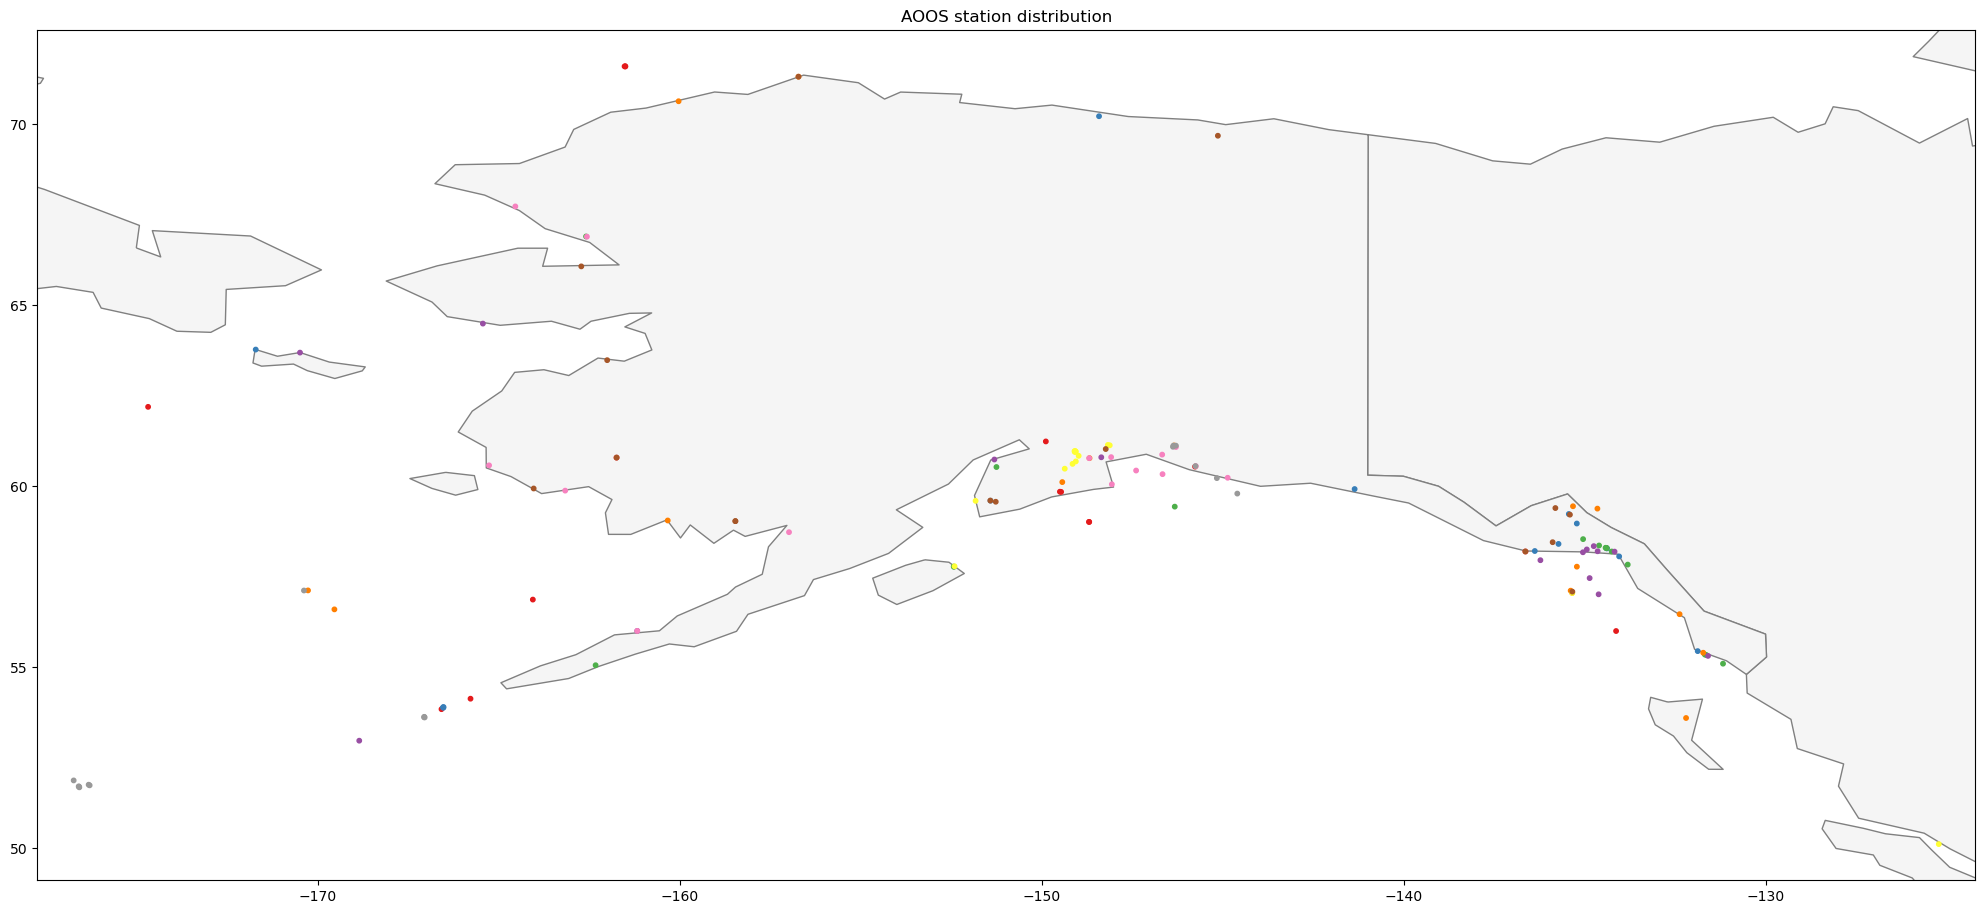

In [15]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='whitesmoke', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         #column='erddap_avail', 
         categorical=True, 
         cmap = 'Set1',
         markersize=10, 
         legend=True,
         legend_kwds={'title': "ERDDAP Available?"},
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

plt.title('{} station distribution'.format(ra))

plt.show()

Make an interactive map.

When you click on a point the return is the information from the inventory.

In [16]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.loc[~gdf_final['geometry'].is_empty == True].drop(columns='Variable Names').explore('erddap_avail',cmap = 'Set1')


## Show me some bad coordinates

_if there are any_

In [17]:
gdf_final.loc[gdf_final['geometry'].is_empty == True]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,erddap_avail,geometry


In [18]:
# import urllib.request
# for url in gdf_final.loc[gdf_final['erddap_not_avail'],'Station Description'].str.replace('url: ',''):
#     print(url)
#     try:
#         urllib.request.urlopen(url).getcode()
#     except:
#         print("URL broken: %s" % url)
#         print(gdf_final.loc[gdf_final['Station Description'].str.contains(url,regex=False),'Station ID'])

# Show me the stations where ERDDAP doesn't exist or provide a valid response.

Reasons:
* Station not found on RA erddap
* dataset found but no data for this CY.

In [19]:
gdf_final.loc[~gdf_final['erddap_avail']]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,erddap_avail,geometry
1,AOOS,CEO1,Not real time,CEO1 (part of the CSEM),NaN,71.5997,-161.5054,moored_buoy,2014-09-21 00:00:00,Y - but never real time,same as above,Yp,UAF-CFOS,Academic,UAF,North Pacific Research Board,"sea_water_temperature, sea_water_electrical_co...",Data visualizaed on the AOOS Portal includes 2...,False,POINT (-161.50540 71.59970)
2,AOOS,CEO2,Not real time,CEO2 (part of the CSEM),NaN,71.5998,-161.5261,moored_buoy,2015-08-20 00:00:00,Y- but never real time,sames as above,Yp,UAF-CFOS,Academic,UAF,North Pacific Research Board,"sea_water_temperature, sea_water_electrical_co...",This is the list of all sensors reporting to t...,False,POINT (-161.52610 71.59980)
3,AOOS,urn:gulf-of-alaska-ecosystem-obse,not reporting real time anymore,Gulf of Alaska Ecosystem Observatory-GEO1,"Surface real time mooring: CDOM, 150kHz ADCP, ...",59.0142,-148.6902,Fixed moored_buoy,2019-07-11 00:00:00,"Y - but not real time at moment, so data not u...","M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,NSF,"Real time mooring: 150kHz ADCP (205m), SBE 37 ...",The buoy was not serving real time data feeds ...,False,POINT (-148.69020 59.01420)
4,AOOS,urn:gulf-of-alaska-ecosystem-obse-1,not reporting real time anymore,Gulf of Alaska Ecosystem Observatory-GEO3,"Surface real time mooring: GPS, wind speed, wi...",59.0165,-148.6966,Fixed moored_buoy,2019-07-11 00:00:00,Y - but not real time at moment,"M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,NSF,"Real time mooring: GPS, wind_speed, wind_from_...","Note: The 5 m SBE 37 CTD (Conductivity, temper...",False,POINT (-148.69660 59.01650)
6,AOOS,urn:ioos:station:gov.noaa.pmel:GAK_Seward,No longer reporting real time on AOOS Portal,GAKOA-Gulf of Alaska Ocean Acidification Mooring,"Resurrection Bay, Seward, Real-time OA parameters",59.85,-149.5,moored_buoy,2011-05-19 00:00:00,Y,"AOOS, NOAA",Yp,NOAA_PMEL,gov_federal,"NOAA PMEL, UAF_OARC",NOAA,"dissolved_carbon_dixoide_ppm, partial_pressure...","Though AOOS Supported, these data are Not repo...",False,POINT (-149.50000 59.85000)
7,AOOS,urn:ioos:station:gov.noaa.pmel:m2,No longer reporting real time on AOOS Portal,M2 - Ocean Acidification Mooring and Ecosytem ...,"Bering Sea, Real-time OA parameters",56.87,-164.06,moored_buoy,1905-07-03 00:00:00,Y,"NOAA, AOOS",Yp,NOAA_PMEL,gov_federal,"NOAA, PMEL, UAF_OARC",NOAA,"dissolved_carbon_dixoide_ppm, partial_pressure...","Though AOOS Supported, the data are Not report...",False,POINT (-164.06000 56.87000)
21,AOOS,urn:ioos:station:org.mxak:GAMBELL,BGBXA2,"Gambell, St. Lawrence Island",Weather and AIS eATON/Transceiver,63.776913,-171.71531,Fixed,2019-05-31 00:00:00,Y,"AOOS, MXAK",Yp,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",NaN,False,POINT (-171.71531 63.77691)
71,AOOS,org-mxak-togiak,NaN,"Tokiak, AK",Weather (AIS Status unknown),59.0551,-160.3336,Fixed,2023-11-16 00:00:00,Y,MXAK,Yp,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",new 2023,False,POINT (-160.33360 59.05510)
88,AOOS,kodiak-burke-o-lator-kodiak-ak,NaN,"Kodiak Burke-o-Lator, Kodiak, AK","NOAA AFSC Operated Kodiak Burke-o-Lator, Kodia...",57.79,-152.41,Fixed,2022-10-01 00:00:00,Y,"NOAA AFSC, AOOS",Yp,NOAA Alaska Fisheries Science Center (AFSC),Federal,NOAA AFSC,IPACOA and NOAA,"dissolved_carbon_dioxide_co2, pco2, omega_arag...",AOOS started supporting BOL operatrions in Kod...,False,POINT (-152.41000 57.79000)
89,AOOS,urn:ioos:station:org.hakai:Sitka,NaN,Sitka Burke-o-Lator,Sitka Tribe of Alaska Burke-O-Lator,

# Do some checking against the IOOS catalog

only for datasets that we couldn't find in ERDDAP (per above)

In [20]:
from ckanapi import RemoteCKAN
import xarray as xr

problem_datasets = []

ua = 'ckanapiioos/1.0 (+https://ioos.us/)'

#ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua, get_only=True)
ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua)
ioos_catalog

gdf_ckan = gdf_final.loc[~gdf_final['erddap_avail']]


for station in gdf_ckan['Station ID'].dropna():

    RA = gdf_ckan.loc[gdf_ckan['Station ID']==station,'RA'].tolist()[0]
    
    print('Station "{}" + RA "{}"'.format(station.lower(), RA.lower()))
    
    # build RA tag query
    fq = '+organization:{}'.format(RA.lower())

    # build free text query
    q = "\""+station.lower()+"\""+" -glider"

    query = ioos_catalog.address + '/dataset/?' + 'q=' + q + '&organization=' + RA.lower()
    
    print('Query: {}'.format(query.replace(" ","%20")))

    datasets = ioos_catalog.action.package_search(q=q, fq=fq)

    

    if datasets['count'] > 0:
        print('\tfound {} dataset(s):'.format(datasets['count']))
        
        for dataset in datasets['results']:
            print('\t',dataset['title'])
            
            
            if dataset['resources']:
                print('\t',dataset['resources'][0]['url'])

                start_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-begin")['value']
                end_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-end")['value']

                print('\t','Coverage Meta:\n\t\t', start_date,' - ',end_date,'\n')

                if 'thredds' in dataset['resources'][0]['url']:
                    ds = xr.open_dataset(dataset['resources'][0]['url'])

                    time_max = ds.time.max().values

                    time_min = ds.time.min().values


                    print('\tCoverage Data:\n\t\t', time_min,' - ',time_max, '\n')

                    if pd.to_datetime(end_date) < pd.to_datetime(time_max, utc=True):
                        test_date = pd.to_datetime(time_max, utc=True)

                else:
                    test_date = pd.to_datetime(end_date, utc=True)

                if test_date > pd.to_datetime('{}-01-01'.format(cy), utc=True):
                    print('\t{} is valid.'.format(station))
                    break
                else:
                    print('\t{} is not valid.'.format(station))

                    problem_datasets.append(station)
            
            else:
                print('\t{} missing additional metadata'.format(station))
                problem_datasets.append(station)
    else:
        print("\tNo datasets found!")
        problem_datasets.append(station)

Station "ceo1" + RA "aoos"
Query: https://data.ioos.us/dataset/?q="ceo1"%20-glider&organization=aoos
	No datasets found!
Station "ceo2" + RA "aoos"
Query: https://data.ioos.us/dataset/?q="ceo2"%20-glider&organization=aoos
	No datasets found!
Station "urn:gulf-of-alaska-ecosystem-obse" + RA "aoos"
Query: https://data.ioos.us/dataset/?q="urn:gulf-of-alaska-ecosystem-obse"%20-glider&organization=aoos
	No datasets found!
Station "urn:gulf-of-alaska-ecosystem-obse-1" + RA "aoos"
Query: https://data.ioos.us/dataset/?q="urn:gulf-of-alaska-ecosystem-obse-1"%20-glider&organization=aoos
	No datasets found!
Station "urn:ioos:station:gov.noaa.pmel:gak_seward" + RA "aoos"
Query: https://data.ioos.us/dataset/?q="urn:ioos:station:gov.noaa.pmel:gak_seward"%20-glider&organization=aoos
	No datasets found!
Station "urn:ioos:station:gov.noaa.pmel:m2" + RA "aoos"
Query: https://data.ioos.us/dataset/?q="urn:ioos:station:gov.noaa.pmel:m2"%20-glider&organization=aoos
	No datasets found!
Station "urn:ioos:stat

Check the datasets that didn't have coverage in ERDDAP or through IOOS catalog and see if they are **Currently Operational?**

In [21]:
gdf_ckan.loc[gdf_ckan['Station ID'].isin(problem_datasets)]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,erddap_avail,geometry
1,AOOS,CEO1,Not real time,CEO1 (part of the CSEM),NaN,71.5997,-161.5054,moored_buoy,2014-09-21 00:00:00,Y - but never real time,same as above,Yp,UAF-CFOS,Academic,UAF,North Pacific Research Board,"sea_water_temperature, sea_water_electrical_co...",Data visualizaed on the AOOS Portal includes 2...,False,POINT (-161.50540 71.59970)
2,AOOS,CEO2,Not real time,CEO2 (part of the CSEM),NaN,71.5998,-161.5261,moored_buoy,2015-08-20 00:00:00,Y- but never real time,sames as above,Yp,UAF-CFOS,Academic,UAF,North Pacific Research Board,"sea_water_temperature, sea_water_electrical_co...",This is the list of all sensors reporting to t...,False,POINT (-161.52610 71.59980)
3,AOOS,urn:gulf-of-alaska-ecosystem-obse,not reporting real time anymore,Gulf of Alaska Ecosystem Observatory-GEO1,"Surface real time mooring: CDOM, 150kHz ADCP, ...",59.0142,-148.6902,Fixed moored_buoy,2019-07-11 00:00:00,"Y - but not real time at moment, so data not u...","M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,NSF,"Real time mooring: 150kHz ADCP (205m), SBE 37 ...",The buoy was not serving real time data feeds ...,False,POINT (-148.69020 59.01420)
4,AOOS,urn:gulf-of-alaska-ecosystem-obse-1,not reporting real time anymore,Gulf of Alaska Ecosystem Observatory-GEO3,"Surface real time mooring: GPS, wind speed, wi...",59.0165,-148.6966,Fixed moored_buoy,2019-07-11 00:00:00,Y - but not real time at moment,"M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,NSF,"Real time mooring: GPS, wind_speed, wind_from_...","Note: The 5 m SBE 37 CTD (Conductivity, temper...",False,POINT (-148.69660 59.01650)
6,AOOS,urn:ioos:station:gov.noaa.pmel:GAK_Seward,No longer reporting real time on AOOS Portal,GAKOA-Gulf of Alaska Ocean Acidification Mooring,"Resurrection Bay, Seward, Real-time OA parameters",59.85,-149.5,moored_buoy,2011-05-19 00:00:00,Y,"AOOS, NOAA",Yp,NOAA_PMEL,gov_federal,"NOAA PMEL, UAF_OARC",NOAA,"dissolved_carbon_dixoide_ppm, partial_pressure...","Though AOOS Supported, these data are Not repo...",False,POINT (-149.50000 59.85000)
7,AOOS,urn:ioos:station:gov.noaa.pmel:m2,No longer reporting real time on AOOS Portal,M2 - Ocean Acidification Mooring and Ecosytem ...,"Bering Sea, Real-time OA parameters",56.87,-164.06,moored_buoy,1905-07-03 00:00:00,Y,"NOAA, AOOS",Yp,NOAA_PMEL,gov_federal,"NOAA, PMEL, UAF_OARC",NOAA,"dissolved_carbon_dixoide_ppm, partial_pressure...","Though AOOS Supported, the data are Not report...",False,POINT (-164.06000 56.87000)
21,AOOS,urn:ioos:station:org.mxak:GAMBELL,BGBXA2,"Gambell, St. Lawrence Island",Weather and AIS eATON/Transceiver,63.776913,-171.71531,Fixed,2019-05-31 00:00:00,Y,"AOOS, MXAK",Yp,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",NaN,False,POINT (-171.71531 63.77691)
88,AOOS,kodiak-burke-o-lator-kodiak-ak,NaN,"Kodiak Burke-o-Lator, Kodiak, AK","NOAA AFSC Operated Kodiak Burke-o-Lator, Kodia...",57.79,-152.41,Fixed,2022-10-01 00:00:00,Y,"NOAA AFSC, AOOS",Yp,NOAA Alaska Fisheries Science Center (AFSC),Federal,NOAA AFSC,IPACOA and NOAA,"dissolved_carbon_dioxide_co2, pco2, omega_arag...",AOOS started supporting BOL operatrions in Kod...,False,POINT (-152.41000 57.79000)
89,AOOS,urn:ioos:station:org.hakai:Sitka,NaN,Sitka Burke-o-Lator,Sitka Tribe of Alaska Burke-O-Lator,57.0526,-135.3456,Fixed,2017-06-27 00:00:00,Y,BIA Climate Change Grant,Yp,Sitka Tribe of Alaska,Tribal,"Sitka Tribe of Alaska, Hakai Institute",IPACOA,"dissolved_carbon_dioxide_co2, pco2, omega_arag...",AOOS supports BoL OnM through Hakai and provid...,False,POINT (-135.34560 57.05260)
90,AOO

Print out the available metadata from the IOOS Catalog for the last dataset.

In [22]:
dataset

{'author': None,
 'author_email': None,
 'creator_user_id': '0ea3933c-4674-41dd-a17d-bfbc8c99bd75',
 'id': 'cb6561fa-0348-454c-aa36-71625d022e94',
 'isopen': False,
 'license_id': None,
 'license_title': None,
 'maintainer': None,
 'maintainer_email': None,
 'metadata_created': '2024-02-19T08:56:48.337628',
 'metadata_modified': '2024-04-01T10:24:17.713442',
 'name': 'togiak-ak',
 'notes': "Timeseries data from 'Togiak, AK' (org_mxak_togiak)",
 'num_resources': 5,
 'num_tags': 28,
 'organization': {'id': 'eb417ed8-8ef9-46e4-8cce-deec54104134',
  'name': 'aoos',
  'title': 'AOOS',
  'type': 'organization',
  'description': '',
  'image_url': 'https://s3.amazonaws.com/ioos-us/images/AOOS_logo.jpg',
  'created': '2022-05-27T16:07:12.556672',
  'is_organization': True,
  'approval_status': 'approved',
  'state': 'active'},
 'owner_org': 'eb417ed8-8ef9-46e4-8cce-deec54104134',
 'private': False,
 'state': 'active',
 'title': 'Togiak, AK',
 'type': 'dataset',
 'url': None,
 'version': None,


In [23]:
# GLOS special case as they provide ERDDAP ID

# for dataset in gdf_final.loc[(~gdf_final['erddap_avail'] & ~gdf_final['Dataset (ERDDAP) ID'].isna()),'Dataset (ERDDAP) ID'].tolist():
#     print(dataset)
#     e.dataset_id = dataset
    
#     e.constraints = {
#                  "time>=": "{}-01-01".format(cy)
#             }
        
#     e.variables = ['time']
    
#     try:
        
#         df_data = e.to_pandas(parse_dates=True)
        
#         string = '\tDate range: {} - {}'.format(df_data.min()[0],df_data.max()[0])
        
#         print(string)
        
#         if pd.to_datetime(df_data.max()[0], utc=True) > pd.to_datetime('{}-01-01'.format(cy), utc=True):
            
#             datasetid = gdf_final.loc[gdf_final['Dataset (ERDDAP) ID']==dataset,'Station ID'].tolist()[0]
            
#             problem_datasets.remove(datasetid)
        
#     except:
#         print('\tNo valid data')

In [24]:
#gdf_ckan.loc[gdf_ckan['Station ID'].isin(problem_datasets)]